# Deep Text Corrector

## Contents

1. Introduction

2. Data Preparation

3. Approaches to the Problem

4. Evaluation Metrices

5. Modelling
    1. Encoder-Decoder Model with Teacher Forcing
    2. Encoder-Decoder Model with Attention Mechanism
    3. Transformers
    4. Attention Mechanism with Transformer based tokenization

6. Future Work

7. References

### 1. Introduction

- This project aims to correct grammatical mistakes in a given English text.
- Grammatical errors are of different types, including errors in articles or determiners, prepositions, noun form, verb form, subject-verb agreement, pronouns, word choice, sentence structure, punctuation, capitalization, etc.
- In this project, we aim to correct 16 types of grammatical errors.

    1. Verb Tense
    2. Subject-Verb agreement
    3. Missing Verb
    4. Article or Determiner
    5. Noun Number
    6. Noun Possessive
    7. Pronoun Reference
    8. Run-on Sentences, Comma Splices
    9. Adjective/Adverb order
    10. Linking words/Phrases
    11. Poor Citation
    12. Parallelism
    13. Improper Preposition Forms
    14. Word Contractions
    15. Capitalization
    16. Spelling


- To achieve this, we train a Deep Learning Model which takes grammatically incorrect text as input and outputs grammatically corrected text.
- Sequence-to-Sequence models are capable of correcting grammatical errors.
- We try different models with different architectures starting from basic encoder-decoder models, encoder-decoder models with attention to Transformers.

### 2. Data Preparation

- Downloaded an English Novel which has grammatically correct text.<a href="https://www.pdfdrive.com/harry-potter-the-complete-collection-e187542062.html">[1]</a> 
- Did some basic pre-processing. Removed contents, chapters' names, etc, to just have only paragraphs with text.
- Did sentence detection using SPACY by setting custom boundaries.<a href="https://realpython.com/natural-language-processing-spacy-python/">[2]</a>

In [6]:
#sentence detection
def set_custom_boundaries(doc):
  for i,token in enumerate(doc[:-1]):
    if token.text == ')' and doc[i-1].text == '.' and i>0:
      doc[i+1].is_sent_start = True
    elif token.text ==  ';' and not doc[i+1].text.islower():
      doc[i+1] .is_sent_start  = True
    elif token.text ==  '!' and not doc[i+1].text.islower():
      doc[i+1] .is_sent_start  = True
    elif token.text ==  '?' and not doc[i+1].text.islower():
      doc[i+1] .is_sent_start  = True
    elif token.text == '”' and (doc[i-1].text=='.' or doc[i-1].text=='?' or doc[i-1].text=='!' or doc[i-1].text==';') and i>0 and not doc[i+1].text.islower():
      doc[i+1].is_sent_start = True
    elif token.text == '.' and doc[i+1].text==')':
      doc[i+1].is_sent_start = False
    elif token.text == '.' and doc[i+1].text!='.' and not doc[i+1].text.islower():
      doc[i+1].is_sent_start = True
    else:
      doc[i+1].is_sent_start  = False
  return doc

- Some of the sentences generated from above process have improper opening and closing quotes, braces. Corrected them to get linguistically meaningful units.
- Removed sentences having only one word.
- Once we got all the grammatically correct meaningful sentences, splitted the data into train, cv and test data.
- Introduced 16 different types of grammatical errors into the datasets.

In [2]:
"""
words after splitting string and tokens in spacy nlp(string) are different
as spacy treats punctuations included in a word as seperate tokens
Eg: 
"'my name don is the 'was the man then".split()
output:
["'my", 'name', 'don', 'is', 'the', "'was", 'the', 'man', 'then']

for t in nlp("'my name don is the 'was the man then"):
  print(t)
output:
'
my
name
don
is
the
'
was
the
man
then

If we observe, apostrophe(') is considered as seperate token in spacy.
Here we are considering punctuations and defining errors. For example, replacing
comma with fullstop, removing opening double quote, etc.
But, we can't replace tokens in spacy.
So, we convert it into string first and find index of the token to be replaced.
Below function finds index, and replaces tokens with error.
"""

#function to replace tokens with errors
def replace_with_error(about_inc,index,to_replace,error):
  l=str(about_inc)
  g=[]
  for i,t in enumerate(about_inc):
    if(i==index) and to_replace==about_inc[index].text:
      idx=t.idx
    elif(i==index):
      idx=t.idx-to_replace.find(about_inc[index].text)
    lent=len(to_replace)
  skip=0
  for i,ch in enumerate(l):
    if skip:
      skip-=1
      continue
    if(i==idx):
      g.append(error)
      skip=lent-1
    else:
      g.append(ch)
  return ''.join(g)

#function to define errors
def get_incorrect_lines(df):
  incorrect_lines=[]
  words_end_with=('ch','ss','sh','x','zz')
  words_ends_with_cont=("'ve","'ll","'s","'m","'d","'re","'t")
  vowels=('ay','ey','iy','oy','uy')
  nlp = spacy.load('en_core_web_sm')
  for i in tqdm(range(len(df.values))):

    about_doc = nlp(df.values[i])
    about_inc=nlp(df.values[i])

    #counts for not repeating same error twice in a line
    count1=0;count2=0;count3=0;count4=0;count5=0;count6=0;count7=0;count8=0
    count9=0;count10=0;count11=0;count12=0;count13=0;count14=0;count15=0;count16=0

    #count for maintaining only two errors per line
    error_count=0

    skip=0
    previous_tokens=[]
    for j,token in enumerate(about_doc):
      #storing tokens
      previous_tokens.append(token.text)

      #getting index for tokens in incorrect lines(about_inc)
      for t in about_inc:
        if about_doc[j].text==t.text:
          index=t.i
          break

      if skip:
        skip -= 1
        continue

      #if same token is present twice in the line, skipping that token
      if about_doc[j].text in previous_tokens[0:-1]:
        skip=1
      if skip:
        skip -= 1
        continue

      #1. replacing Verb Past Tense(VBD) to Verb present tense: were --> are, saw --> see
      if  token.tag_ == 'VBD' and about_inc[index].text!=token.lemma_ and about_inc[index].text[0].islower() and count1==0 and error_count<=2:
        about_inc=nlp(replace_with_error(about_inc,index,about_inc[index].text,token.lemma_))
        count1=1


      #2. Subject-verb agreement: they go -->they goes,we watch  -->we watches
      elif token.tag_ ==  'VBP':
        for t in nlp(str(token)):
          if t.tag_ == 'VB':
            if about_inc[index].text.endswith(words_end_with) or about_inc[index].text == 'go' or about_inc[index].text == 'do' and count2==0 and error_count<=2:
                about_inc=nlp(replace_with_error(about_inc,index,about_inc[index].text,about_inc[index].text+'es'))
                count2=1

            elif about_inc[index].text.endswith(vowels) and count2==0:
              about_inc=nlp(replace_with_error(about_inc,index,about_inc[index].text,about_inc[index].text+'s'))
              count2=1

            elif about_inc[index].text.endswith('y') and count2==0:
              about_inc=nlp(replace_with_error(about_inc,index,about_inc[index].text,about_inc[index].text.replace('y','ies')))
              count2=1

            elif about_inc[index].text == 'be' and count2==0:
              about_inc=nlp(replace_with_error(about_inc,index,about_inc[index].text,'is'))
              count2=1

            elif about_inc[index].text.endswith('s') and count2==0:
              about_inc=nlp(replace_with_error(about_inc,index,about_inc[index].text,about_inc[index].text+'ses'))
              count2=1

            elif about_inc[index].text.endswith('z') and count2==0:
              about_inc=nlp(replace_with_error(about_inc,index,about_inc[index].text,about_inc[index].text+'zes'))
              count2=1


        #3. Missing verb: However, there are also a great number of people [who → who are] against
        if about_inc[index-1].tag_ == 'WP' and j!=0 and count3==0:
          about_inc=nlp(replace_with_error(about_inc,index,about_inc[index].text+" ",""))
          count3=1


      #4. Removing Articles
      elif about_inc[index].text=='a' or about_inc[index].text=='an' or about_inc[index].text=='the' and count4==0:
        about_inc=nlp(replace_with_error(about_inc,index,about_inc[index].text+" ",""))
        count4=1


      #5. Noun number: children --> child
      elif token.tag_  == 'NNS' and about_inc[index].text!=token.lemma_ and about_inc[index].text[0].islower() and count5==0:
        about_inc=nlp(replace_with_error(about_inc,index,about_inc[index].text,token.lemma_))
        count5=1


      #6. Noun possessive: carrier's --> carriers
      elif about_inc[index].text=="'s" and count6==0:
        about_inc=nlp(replace_with_error(about_inc,index,about_inc[index].text,'s'))
        count6=1


      #7. Pronoun reference: they --> he/she
      elif about_inc[index].text == 'they' and count7==0:
        about_inc=nlp(replace_with_error(about_inc,index,about_inc[index].text,'he'))
        count7=1


      #8. Run-on sentences,comma splices: The issue is highly [debatable, a → debatable. A] genetic risk
      elif about_inc[index].text.islower() ==  False and about_inc[index].text!='“' and str(about_inc[index-1]) == '.' \
      and not str(about_inc).startswith(about_inc[index].text) and not str(about_inc).endswith('.') and about_inc[index].text!='I' and count8==0:
        about_inc=nlp(replace_with_error(about_inc,index,about_inc[index-1].text+" "+about_inc[index].text,', '+about_inc[index].text.lower()))
        count8=1


      #9. Incorrect adjective/adverb order: In conclusion, [personally I → I personally] feel that it
      elif token.tag_ == 'RB' and count9==0 and not "'" in about_inc[index].text and len(about_inc[index].text)>=2 and not str(about_inc).startswith(about_inc[index].text):
        punc=0
        for p in string.punctuation:
          if p not in about_inc[index].text or p not in about_inc[index-1].text:
            punc=1
            break
        if(punc==0):
          about_inc=nlp(replace_with_error(about_inc,index,about_inc[index-1].text+" "+about_inc[index].text,about_inc[index].text+" "+about_inc[index-1].text))
          count9=1


      #10. Linking words/phrases: It is sometimes hard to find [out → out if] one has this disease.
      elif token.tag_ == 'IN' and j!=0 and count10==0:
        about_inc=nlp(replace_with_error(about_inc,index,about_inc[index].text+" ",""))
        count10=1

      #11. Poor citation
      elif (about_inc[index].text == '“') and count11==0:
        temp=str(about_inc)
        for word in temp.split():
          if word.startswith('“'):
            word1=word.replace('“','“ ')
            temp=temp.replace(word,word1)
          elif word.endswith('”'):
            word1=word.replace('”',' ”')
            temp=temp.replace(word,word1)
        if '“' in temp.split() and j!=temp.split().index('“') and not temp.endswith('”'):
          about_inc=nlp(replace_with_error(about_inc,index,about_inc[index].text,""))
          count11=1


      #13. Parallelism: We must pay attention to this information and [assisting → assist] those
      elif about_inc[index].text.endswith('ing') and about_inc[index-1].tag_ == 'CC' and about_inc[index].text!=token.lemma_ and about_inc[index].text[0].islower() and count13==0:
        about_inc=nlp(replace_with_error(about_inc,index,about_inc[index].text,token.lemma_))
        count13=1


      #14. Improper preposition forms: This essay will [discuss about → discuss] whether a carrier
      elif 'discuss' in about_inc[index].text and count14==0:
        about_inc=nlp(replace_with_error(about_inc,index,about_inc[index].text,about_inc[index].text+" "+'about'))
        count14=1

      elif about_inc[index].text=='through' and count14==0:
        about_inc=nlp(replace_with_error(about_inc,index,about_inc[index].text,'to'))
        count14=1

      elif about_inc[index].text=='into' and count14==0:
        about_inc=nlp(replace_with_error(about_inc,index,about_inc[index].text,'in'))
        count14=1

      elif about_inc[index].text=='since' and count14==0:
        about_inc=nlp(replace_with_error(about_inc,index,about_inc[index].text,'for'))
        count14=1


      #15. Removing word contractions: I've-->I, we'll-->we, let's-->let
      elif about_inc[index].text.endswith(words_ends_with_cont) and count15==0:
        if about_inc[index].text == "n't":
          about_inc=nlp(replace_with_error(about_inc,index,"'t",""))
        else:
          about_inc=nlp(replace_with_error(about_inc,index,about_inc[index].text,""))
        count15=1


      #16. upper to lower, lower to upper:
      elif len(str(about_inc).split())<=2 and count16==0:
        if about_inc[index].text.isupper():
          about_inc=nlp(replace_with_error(about_inc,index,about_inc[index].text,about_inc[index].text.lower()))
          count16=1

        else:
          about_inc=nlp(replace_with_error(about_inc,index,about_inc[index].text,about_inc[index].text.upper()))
          count16=1


      #12. Incorrect Spelling
      elif len(about_inc[index].text)>2 and about_inc[index].tag_ != 'WP' and about_inc[index].tag_ != 'NNP' and "'" not in about_inc[index].text and "'" not in about_inc[index+1].text and count12==0:
        if "'" not in about_inc[index-1].text or str(about_inc).startswith(about_inc[index].text):
          #swapping letters for wrong spelling
          c1=about_inc[index].text[1]
          c2=about_inc[index].text[2]
          c0=about_inc[index].text[0]
          if c1!=c2:
            d=about_inc[index].text.replace(c2,"-",1)
            d=d.replace(c1,c2,1)
            d=d.replace(d[2],c1,1)
          else:
            d=about_inc[index].text.replace(c1,c0,1)
          about_inc=nlp(replace_with_error(about_inc,index,about_inc[index].text,d))
          count12=1


      #skipping tokens to avoid errors in three adjacent tokens
      if index>=len(about_inc):
        skip=2
      elif about_inc[index].text != about_doc[j].text:
        skip=2

    incorrect_lines.append(str(about_inc))

  return incorrect_lines

- After introducing errors into the sentences, introuduced space between words and punctuations in the sentences as punctuations need to be considered as seperate tokens while tokenization. Eg: '__I am good.__' - '__I am good .__' (space between good and fullstop)
- With this, we get proper train, cv, test datas with grammatically incorrect input sentences and grammatically correct output sentences.

Complete Code for Pre-Processing and Introducting errors @ https://github.com/VyshnaviVanjari/Deep_Text_Corrector/blob/main/preprocessing_add_errors.ipynb

### 3. Approaches to the Problem
- Encoder-Decoder models using RNNs is one of the approaches to this problem. However, this has a disadvatange of having a fixed length context vector which is incapable of remembering long sentences. <a href="https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html">[3]</a>
- The attention mechanism helps to memorize long source sentences in neural machine translation. Rather than building a single context vector from the encoder's last hidden state, attention creates shortcuts between the context vector and the entire source input.<a href="https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html#:~:text=The%20attention%20mechanism%20was%20born%20to%20help%20memorize%20long%20source,and%20the%20entire%20source%20input">[4]</a>
- Attention mechanism is a very good approach to this problem but the only problem is with Out of Vocabulary(OOV) words. 
- Transformers are a great solution to this. Transformer tokenizers provide sub-word tokenization, byte-pair encoding, etc., and so there will be no problem in tokenizing OOV words.<a href="https://huggingface.co/transformers/tokenizer_summary.html">[5]</a>

### 4. Evaluation Metrices
- Chosen F0.5 as the evaluation metric similar to that in  CoNLL-2014 shared task on grammatical error correction. F0.5 emphasizes precision twice as much as recall, while F1 weighs precision and recall equally. When a grammar checker is put into actual use, it is important that its proposed corrections are highly accurate in order to gain user acceptance. Neglecting to propose a correction is not as bad as proposing an erroneous correction.<a href="https://www.aclweb.org/anthology/W14-1701.pdf">[6]</a> <a href="https://machinelearningmastery.com/fbeta-measure-for-machine-learning/#:~:text=F%2DMeasure%20%3D%20(2%20*,)%20%2F%20(Precision%20%2B%20Recall)">[7]</a>

    Precision = True Positives/(True Positives + False Positives)

    Recall = True Positives/(True Positives + False Negatives)

    F1-Score = (2 * Precision * Recall) / (Precision + Recall)
    
   __Fbeta = ((1 + beta^2) * Precision * Recall) / (beta^2 * Precision + Recall)__
    
    __F0.5-score (beta=0.5): More weight on precision, less weight on recall.__
    

- During inference, reported BLEU scores, perplexity along with F0.5 score.<a href="https://machinelearningmastery.com/calculate-bleu-score-for-text-python/">[8]</a> <a href="https://en.wikipedia.org/wiki/Perplexity">[9]</a>


### 5. Modelling

#### A. Encoder Decoder Model with Teacher Forcing

- Below figure shows an encoder decoder model with teacher forcing.

        Input: Harry say nothing.
        Expected Output: Harry said nothing.

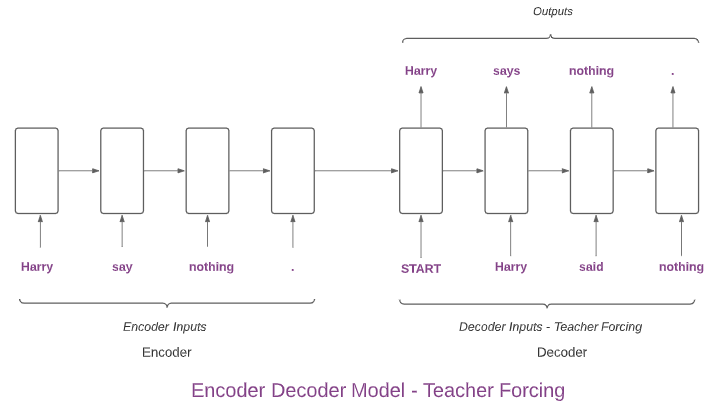

- Data needs to be tokenized and embedded before sending to encoder and decoder.
- As we can see in the above figure, we send the input sentence(embedded one) to the encoder. Here encoder and decoders are RNNs like LSTMs. 
- Encoder encodes the sentence and the last hidden state has all the sentence information.
- This last hidden state of encoder is sent as the initial state to the decoder.
- During training, we use teacher forcing technique to send inputs to the decoder.
- In teacher forcing, the input to the decoder at the next time step will be the actual expected output of the previous time step but not the predicted output. We can observe this in the above figure. At second time step, the predicted output is 'says'. Instead of this, we send the actual output 'said' as input in the next time step. In this way, the model can learn effectively.

Below is the code snippet for creating encoder-decoder model with teacher forcing.

In [ ]:
encoder_inputs = Input(shape=(None,), name="enc_input_layer")

embed = Embedding(input_dim=vocab_size, output_dim=300,
                  weights=[embedding_matrix],
                  trainable=False,
                  name="enc_dec_embedding_layer")
enc_embed=embed(encoder_inputs)

'''return states and discard output as we will use only the encoder states at the last
timestep which is the context vector as input for the decoder'''
encoder_out,state_h,state_c = LSTM(300,return_state=True,name="enc_lstm_layer")(enc_embed)
encoder_states=[state_h,state_c]

decoder_inputs = Input(shape=(None,),name='dec_input_layer')
dec_embed=embed(decoder_inputs)
decoder_out,state_h,state_c=LSTM(300,return_state=True,return_sequences=True)(dec_embed,initial_state=encoder_states)
dec_dense=Dense(vocab_size, activation='softmax')(decoder_out)
    
encoder_decoder_model = Model(inputs=[encoder_inputs,decoder_inputs], outputs=dec_dense, name="encoder_decoder_model")

- This model didn't predict well. 
- The main disadvantage with encoder-decoder models is that the context vector(last hidden state of encoder) fails to remember long sentences as it has fixed length.
- Hence, we proceeded with attention mechanism.

#### B. Encoder-Decoder Model with Attention Mechanism

- Below figure shows Attention Mechanism. This figure is from Lilian Weng's blog.<a href="https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html#:~:text=The%20attention%20mechanism%20was%20born%20to%20help%20memorize%20long%20source,and%20the%20entire%20source%20input">[4]</a>

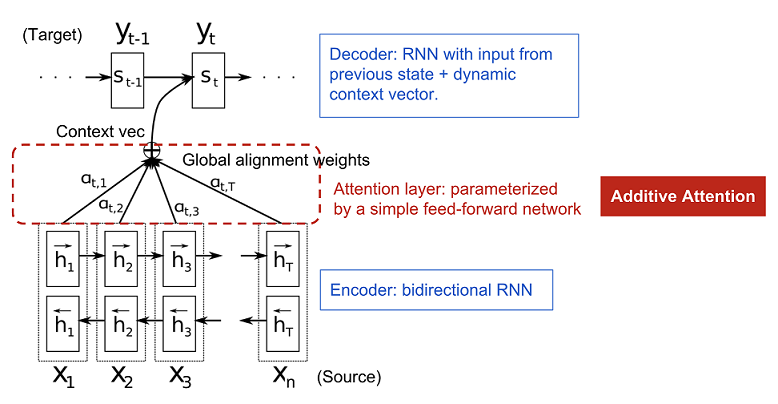
<center><a href="https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html">Image Source</a></center>

- Encoder is a bidirectional RNN(can also be unidirectional) and decoder is a unidirectional RNN.
- As done in basic encoder decoder model, we send input sentence to the encoder. We get forward and backward encoder hidden states at each timestep.
- We get final encoder states(hi) by concatenating the forward and backward states at each timestep.
- Input to the decoder at each timestep is the concatenation of expected output of previous time step and context vector. Decoder hidden state will be passed to the next time step.
- Unlike basic encoder-decoder models where context vector is calculated only once and of fixed length, in attention, we calculate context vector at every time step.
- Below are the equations to calculate context vector.
    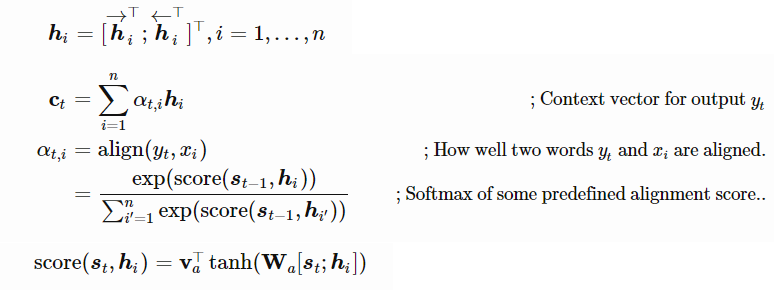
    <center><a href="https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html">Source For Equations</a></center>
    
    

- Below is the explanation for calculating context vector.

    1. Initial hidden state of decoder, s0 is computed by taking tanh of encoder backward hidden state.
    2. First we assign scores to a pair of decoder and encoder hidden states based on how well they match. Lets consider s0 as the initial hidden state of decoder and h1 as the encoder hidden state at first time step. We assign a score for them using the score equation pointed above where va, Wa are weight matrices. Similarly, we assign scores to s0, h2(encoder hidden state at second time step) and so on. Finally, we get scores for the pairs: (s0,h1), (s0,h2),..,(s0,hn).
    3. Attention weights define how much of each source hidden state should be considered for each output. We calculate attention weights by applying softmax to the scores. Let alpha denotes attention weight.
    
        1. Lets calculate attention weights for the first time step at decoder.</br>
        
            alpha 1,1 = softmax(score(s0,h1))</br>
            
            alpha 1,2 = softmax(score(s0,h2))</br>
            
            .......................................................</br>
            
            alpha 1,n = softmax(score(s0,hn))</br>
            
    4. Now we have all the attention weights for the first time step which define which inputs are most important for the output at this time step.
    5. Now we can get context vector for the first time step by calculating dot product of above attention weights(alpha 1,1,alpha 1,2,...,alpha 1,n) and all encoder hidden states(h1,h2,...,hn). Context vector is the summation of hidden states of the input sequence weighted by alignment scores.
    
- In the similar way, we can calculate context vectors at each time step of the decoder.
- As context vector has access to the entire input sequence at each time step, it can memorize long sequences and there are no worries of forgetting.

Below is the code snippet for creating encoder-decoder model with attention mechanism.

In [ ]:
#https://arxiv.org/pdf/1409.0473.pdf
#https://www.tensorflow.org/tutorials/text/nmt_with_attention
#https://udai.gitbook.io/practical-ml/nn/training-and-debugging-of-nn

#fixing numpy RS
np.random.seed(42)
#fixing tensorflow RS
tf.random.set_seed(32)
#python RS
rn.seed(12)

hidden_units=512

#encoder inputs
encoder_inputs = Input(shape=(max_length,),dtype=tf.int64,name="enc_input_layer")

#encoder_mask
encoder_mask = Input(shape=(max_length,),dtype=tf.int64,name="encoder_mask")

#decoder inputs
decoder_input = Input(shape=(max_length,),dtype=tf.int64,name='dec_input_layer')

#decoder_mask
decoder_mask = Input(shape=(max_length,),dtype=tf.int64,name="decoder_mask")

#Embedding layer
embed_layer = Embedding(len(tokenizer),output_dim=512,name='enc_dec_embedding_layer')
encoder_GRU_layer_1=GRU(hidden_units,dropout=0.1,return_sequences=True,name='encoder_GRU_layer_1')
encoder_GRU_layer_2=GRU(hidden_units,dropout=0.1,return_sequences=True,name='encoder_GRU_layer_2')
encoder_GRU_layer_3=GRU(hidden_units,dropout=0.1,return_sequences=True,return_state=True,name='encoder_GRU_layer_3')

enc_embed=embed_layer(encoder_inputs)
encoder_out=encoder_GRU_layer_1(enc_embed)
encoder_out=encoder_GRU_layer_2(encoder_out)
encoder_out,encoder_hidden=encoder_GRU_layer_3(encoder_out)

weights_dense_layer1=Dense(hidden_units,name='attn_score_weights_layer1')
weights_dense_layer2=Dense(hidden_units,name='attn_score_weights_layer2')
score_dense_layer=Dense(1,name='attn_score_dense_layer')

decoder_GRU_layer_1=GRU(hidden_units,dropout=0.1,return_sequences=True,return_state=True,name='decoder_GRU_layer_1')
decoder_GRU_layer_2=GRU(hidden_units,dropout=0.1,return_sequences=True,name='decoder_GRU_layer_2')
layer_normalization=LayerNormalization(name='layer_norm_layer')
#final dense layer
decoder_dense = Dense(len(tokenizer),activation='softmax',name='dec_dense_layer')

decoder_hidden=tf.nn.tanh(encoder_hidden)
all_outputs=[]
for i in tqdm(range(max_length)):
  #teacher forcing - giving actual output of previous time step as input - initial input is 'START' 
  dec_inp=tf.gather(decoder_input,[i],axis=1)
  dec_mask=tf.gather(decoder_mask,[i],axis=1)
  #we are doing this to broadcast addition along the time axis to calculate the score
  decoder_hidden_with_time_axis=tf.expand_dims(decoder_hidden,1)

  #getting context_vector from attention layer
  score=score_dense_layer(tf.nn.tanh(weights_dense_layer1(decoder_hidden_with_time_axis)+weights_dense_layer2(encoder_out)))
  score=tf.squeeze(score,[-1])

  scores_mask=tf.cast(encoder_mask,dtype=tf.bool)
  padding_mask = tf.logical_not(scores_mask)
  score-=1.e9 * tf.cast(padding_mask, dtype=score.dtype)

  attention_weights=tf.nn.softmax(score,axis=1)
  attention_weights = tf.expand_dims(attention_weights, 1)
  context_vector=tf.matmul(attention_weights,encoder_out)
  context_vector=tf.squeeze(context_vector,1)

  context_vector*=tf.cast(tf.cast(dec_mask,dtype=tf.bool),dtype=context_vector.dtype)

  dec_inp=embed_layer(dec_inp)
  dec_inp=tf.concat([tf.expand_dims(context_vector,1),dec_inp],axis=-1)
  decoder_out,decoder_hidden=decoder_GRU_layer_1(dec_inp,initial_state=decoder_hidden)
  decoder_out=layer_normalization(decoder_out)
  decoder_out=decoder_GRU_layer_2(decoder_out)
  decoder_out=layer_normalization(decoder_out)
  decoder_out=decoder_GRU_layer_2(decoder_out)
  decoder_out=layer_normalization(decoder_out)
  out=decoder_dense(decoder_out)
  all_outputs.append(out)

decoder_outputs=Lambda(lambda x: concatenate(x,axis=1))(all_outputs)

attn_model = Model(inputs=[encoder_inputs,encoder_mask,decoder_input,decoder_mask],outputs=decoder_outputs,name='attn_model')

- This encoder-decoder model with attention mechanism performed so well in correcting grammatical errors when compared to basic encoder-decoder model.
- However, it can't predict OOV words and in test data we have many OOV words.
- Transformers are the best in predicting OOV words as the tranformer tokenizer uses sub-word tokenization or byte-pair encoding to tokenize the words.<a href="https://huggingface.co/transformers/tokenizer_summary.html">[10]</a> Hence, proceeded modelling with transformers.

#### C. Transformers

- Transformers, especially BERT is one of the latest milestones in handling language based tasks.
- Hugging Face provides many libraries with pre-trained Transformer models.<a href="https://huggingface.co/transformers/">[11]</a>
- There are different transformer models like BERT, GPT, GPT2, Roberta, XLNet, etc,.
- Some transformer models have only encoder part and some have only decoders.
- Encoder and Decoders in Transformer models are different from those we have discussed above.
- Encoder part is composed of many encoder layers where each layer has self attention layer, feed forword layer.
- Decoder part is composed of many decoder layers where each layer has self attention layer, encoder-decoder-attention layer, and feed forward layer.
- These encoder and decoder parts are different for different transformer models. There are masked self-attention layers in some transformer models.
- Here are great blogs written by Jay Alammar in which he clearly explained every part of the Transformer model.<a href="http://jalammar.github.io/illustrated-transformer/">[12]</a> <a href="http://jalammar.github.io/illustrated-bert/">[13]</a>

    http://jalammar.github.io/illustrated-transformer/

    http://jalammar.github.io/illustrated-bert/
    

- Tried modelling with GPT2 Transformer and the model is good in correcting grammatical errors and also in predicting OOV words.
- However, this model is very large. It has huge parameters. Time complexity is high and also this is difficult to deploy.
- Hence, fell back to previous attention mechanism shown in section B and to handle OOV words used transformer based tokenization using pre-tranined tokenizers from hugging face library.

#### D. Attention Mechanism with Transformer based tokenization

- Used GPT2 Tokenizer from Hugging Face library to tokenize the data.
- GPT2 Tokenizer uses byte-pair encoding for tokenization.<a href="https://huggingface.co/transformers/tokenizer_summary.html">[10]</a>
- GPT2 Tokenizer calculates Byte-pair encoding as shown below.
    1. Count the frequency of each word in the training corpus. Now, we have each word and its corresponding frequency.
    2. Get the base vocabulary with all the characters from the words and then split the words by character.
    3. From all the splitted words, take each pair of symbols(characters) and get the most frequent pair and merge them.
    4. Form merge rules until we get the desired vocabulary size.
    5. As the base vocabulary contains almost all English alphabets, OOV words can be tokenized.

Below is the code snippet to tokenize the data using GPT2Tokenizer.

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
#cls_token is the start token of the sentence and eos_token is the end token of the sentence
tokenizer.add_special_tokens({"cls_token" : "<cls>","eos_token" : "<eos>","pad_token": "<pad>"})

train_input_ids, train_input_masks = [],[]
for sentence in tqdm(train['incorrect_lines']):
  train_inputs = tokenizer.encode_plus(tokenizer.cls_token+sentence, add_special_tokens=True, max_length=max_length,pad_to_max_length=True,
                                        return_attention_mask=True, truncation=True)
  train_input_ids.append(train_inputs['input_ids'])
  train_input_masks.append(train_inputs['attention_mask'])

- Passed tokenized data as inputs to the attention model.
- This model is able to correct the grammatical erros well and also able to predict OOV words.

Below picture shows the predicted sentences and BLEU scores during inference.

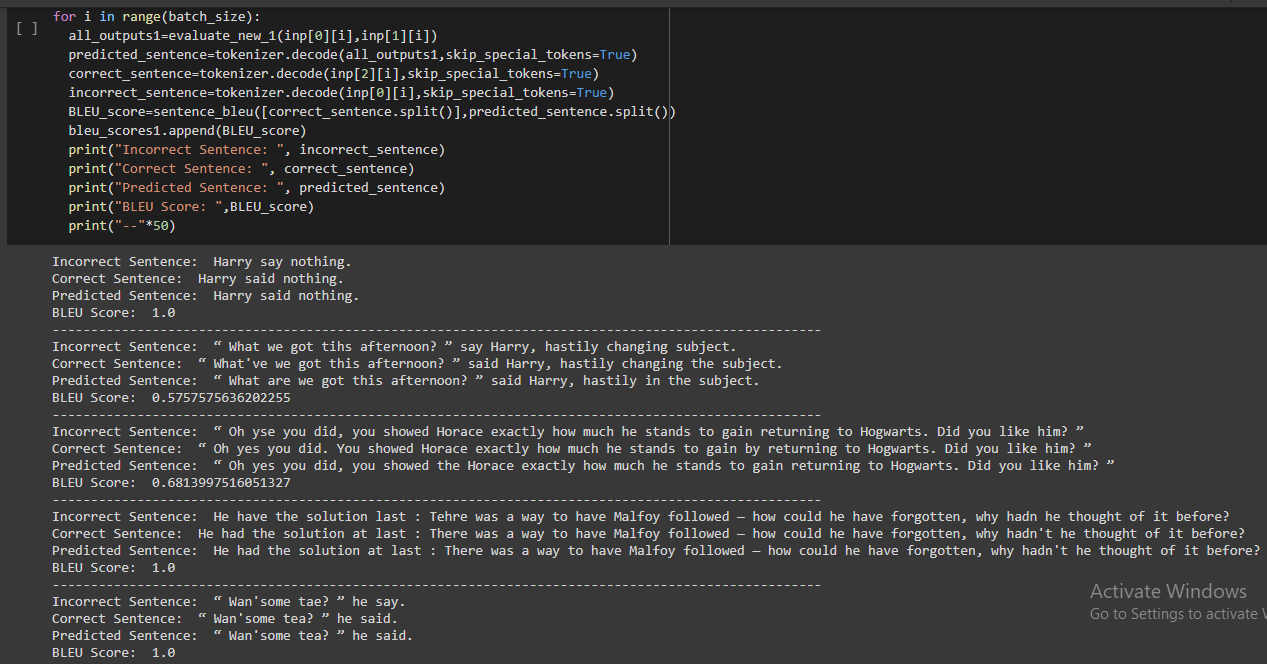

__Final Result on Test Data:__
- F0.5 score = 0.67
- Perplexity = 35.48485

Code for Training and Inference @ https://github.com/VyshnaviVanjari/Deep_Text_Corrector/blob/main/training_inference.ipynb

__Error Analysis:__

__Errors model corrected properly:__

- Most of the spelling mistakes are properly corrected.
- Some errors have wrong verb tense as present tense. Verb past tense is properly predicted.
- Some articles were removed and for these errors, articles are correclty predicted.
- Some linking words were missing like if, in, at, from, for etc,. Some of these errors are corrected.
- Word contractions like 've, 't, 's, 'll, etc., were removed. Some of these errors are corrected.
- Full stop and comma were interchanged and some of these errors are corrected.
- Missing quotes are corrected.

__Erros model failed to correct:__

- Some words are wrongly predicted.
- Some errors with combined punctuation and upper case lower case errors are not properly corrected.(eg. , yes --> . Yes)
- Some linking words were missing and are not predicted.
- 'in' is wrongly predicted as 'into' sometimes.
- Most of the verb forms are predicted properly but few verb forms are not predicted correctly.
- Some articles are not predicted properly.
- Some word contractions like 'd are predicted which are not necessary.
- There are some errors with plurals, and some of these are predicted as singulars.

### 6. Future Work

- From the above analysis, we can observe that the model is able to correct different kind of errors and at the same time failed to correct same kind of errors. 
- Almost all spelling mistakes are corrected properly and most of the verb forms are corrected properly. 
- Some errors are not trained properly as these errors are few. 
- With much more data and by applying these errors to large data, we can train and predict much more efficiently.
- Transformer modelling is a great approach to this problem. Using quantization, we can reduce the model parameters and can try to build the model efficiently.

### 7. References

1. [https://www.pdfdrive.com/harry-potter-the-complete-collection-e187542062.html](https://www.pdfdrive.com/harry-potter-the-complete-collection-e187542062.html)
2. [https://realpython.com/natural-language-processing-spacy-python/](https://realpython.com/natural-language-processing-spacy-python/)
3. [https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)
4. [https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html#:~:text=The%20attention%20mechanism%20was%20born%20to%20help%20memorize%20long%20source,and%20the%20entire%20source%20input](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html#:~:text=The%20attention%20mechanism%20was%20born%20to%20help%20memorize%20long%20source,and%20the%20entire%20source%20input)
5. [https://huggingface.co/transformers/tokenizer_summary.html](https://huggingface.co/transformers/tokenizer_summary.html)
6. [https://www.aclweb.org/anthology/W14-1701.pdf](https://www.aclweb.org/anthology/W14-1701.pdf)
7. [https://machinelearningmastery.com/fbeta-measure-for-machine-learning/#:~:text=F%2DMeasure%20%3D%20(2%20*,)%20%2F%20(Precision%20%2B%20Recall)](https://machinelearningmastery.com/fbeta-measure-for-machine-learning/#:~:text=F%2DMeasure%20%3D%20(2%20*,)%20%2F%20(Precision%20%2B%20Recall))
8. [https://machinelearningmastery.com/calculate-bleu-score-for-text-python/](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/)
9. [https://en.wikipedia.org/wiki/Perplexity](https://en.wikipedia.org/wiki/Perplexity)
10. [https://huggingface.co/transformers/tokenizer_summary.html](https://huggingface.co/transformers/tokenizer_summary.html)
11. [https://huggingface.co/transformers/](https://huggingface.co/transformers/)
12. [http://jalammar.github.io/illustrated-transformer/](http://jalammar.github.io/illustrated-transformer/)
13. [http://jalammar.github.io/illustrated-bert/](http://jalammar.github.io/illustrated-bert/)


__Thanks for Reading😃__

__Complete code in github: https://github.com/VyshnaviVanjari/Deep_Text_Corrector__

__Reach me at Linkedin: https://www.linkedin.com/in/vyshnavi-vanjari-57345896/__